In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nibabel as nib
from glob import glob
import random
from scipy.stats import mannwhitneyu

In [3]:
#compare tract atlases
tracts=["ac","af_l","af_r","ar_l", "ar_r", "atr_l", "atr_r", "cbd_l", "cbd_r", "cbp_l", "cbp_r", "cbt_l", "cbt_r",
       "cst_l", "cst_r", "fa_l", "fa_r", "fma", "fmi", "fx_l", "fx_r", "ifo_l", "ifo_r", "ilf_l", "ilf_r", "mcp",
       "mdlf_l", "mdlf_r", "or_l", "or_r", "slf1_l", "slf1_r", "slf2_l", "slf2_r", "slf3_l", "slf3_r", "str_l", 
       "str_r", "uf_l", "uf_r", "vof_l", "vof_r"]

data_dir = "/Users/shaunwarrington/Documents/baby_xtract_git/Data"
# mask = nib.load(f'{data_dir}/mask.nii.gz')
# mask = np.asanyarray(mask.dataobj) 

dhcp_subjects=pd.read_csv(f'{data_dir}/ox_matched_dhcp.csv')
oxford_subjects=pd.read_csv(f'{data_dir}/oxford_data.csv')

###### already processed and saved, simply load from below
# thr = 0.3
# C=np.empty(0)
# for t in tracts:
#     ox_atlas=nib.load(f'{data_dir}/oxford_downsampled_av/thr_0.001/{t}.nii.gz')
#     ox_atlas = np.asanyarray(ox_atlas.dataobj)[mask==1]
#     ox_atlas[ox_atlas<thr]=0
#     dhcp_atlas=nib.load(f'{data_dir}/dHCP_av/thr_0.001/{t}.nii.gz')
#     dhcp_atlas = np.asanyarray(dhcp_atlas.dataobj)[mask==1]
#     dhcp_atlas[dhcp_atlas<thr]=0
    
#     C = np.append( C,np.corrcoef(ox_atlas, dhcp_atlas)[0,1])
    
# print("mean = {}, stdev = {}".format(np.mean(C), np.std(C)))

In [4]:
n_subjects = len(oxford_subjects)
n_tracts = len(tracts)

In [5]:
##### load
df = pd.DataFrame(columns=["groups", "tract","sub1", "sub2", "Correlation (r)"])

for group in ["dHCP_dHCP", "ox_ox", "lowres_lowres", "dHCP_ox", "dHCP_lowres"]:
    for t in tracts:
        file=f'{data_dir}/correlations/{group}_{t}.txt'
        for line in open(file):
                sub1, sub2, corr = line.split()
                sub1 = int(sub1)
                sub2 = int(sub2)
                corr = float(corr)
                if sub1 < sub2:
                    df = df.append({
                        "groups":group,
                        "sub1":sub1,
                        "sub2":sub2,
                        "tract":t,
                        "Correlation (r)":corr
                    }, ignore_index=True)


In [6]:
df_sum = df.groupby(["sub1", "sub2", "groups"]).mean()

In [7]:
df_sum = df_sum.reset_index()

In [8]:
df_sum

,sub1,sub2,groups,Correlation (r)
0,1,2,dHCP_dHCP,0.496667
1,1,2,dHCP_lowres,0.391746
2,1,2,dHCP_ox,0.413810
3,1,2,lowres_lowres,0.560000
4,1,2,ox_ox,0.607976
...,...,...,...,...
1150,21,22,dHCP_dHCP,0.515000
1151,21,22,dHCP_lowres,0.391626
1152,21,22,dHCP_ox,0.404286
1153,21,22,lowres_lowres,0.448943


In [9]:
df_sum["groups"].value_counts()

dHCP_dHCP        231
dHCP_lowres      231
dHCP_ox          231
lowres_lowres    231
ox_ox            231
Name: groups, dtype: int64

In [10]:
labels={"dHCP_dHCP":"dHCP to dHCP", 
        "ox_ox":"Oxford to Oxford", 
        "lowres_lowres":"DTI to DTI", 
        "dHCP_ox": "dHCP to Oxford", 
        "dHCP_lowres": "dHCP to DTI"}

In [11]:
df_sum = df_sum.replace(labels)
df_sum

,sub1,sub2,groups,Correlation (r)
0,1,2,dHCP to dHCP,0.496667
1,1,2,dHCP to DTI,0.391746
2,1,2,dHCP to Oxford,0.413810
3,1,2,DTI to DTI,0.560000
4,1,2,Oxford to Oxford,0.607976
...,...,...,...,...
1150,21,22,dHCP to dHCP,0.515000
1151,21,22,dHCP to DTI,0.391626
1152,21,22,dHCP to Oxford,0.404286
1153,21,22,DTI to DTI,0.448943


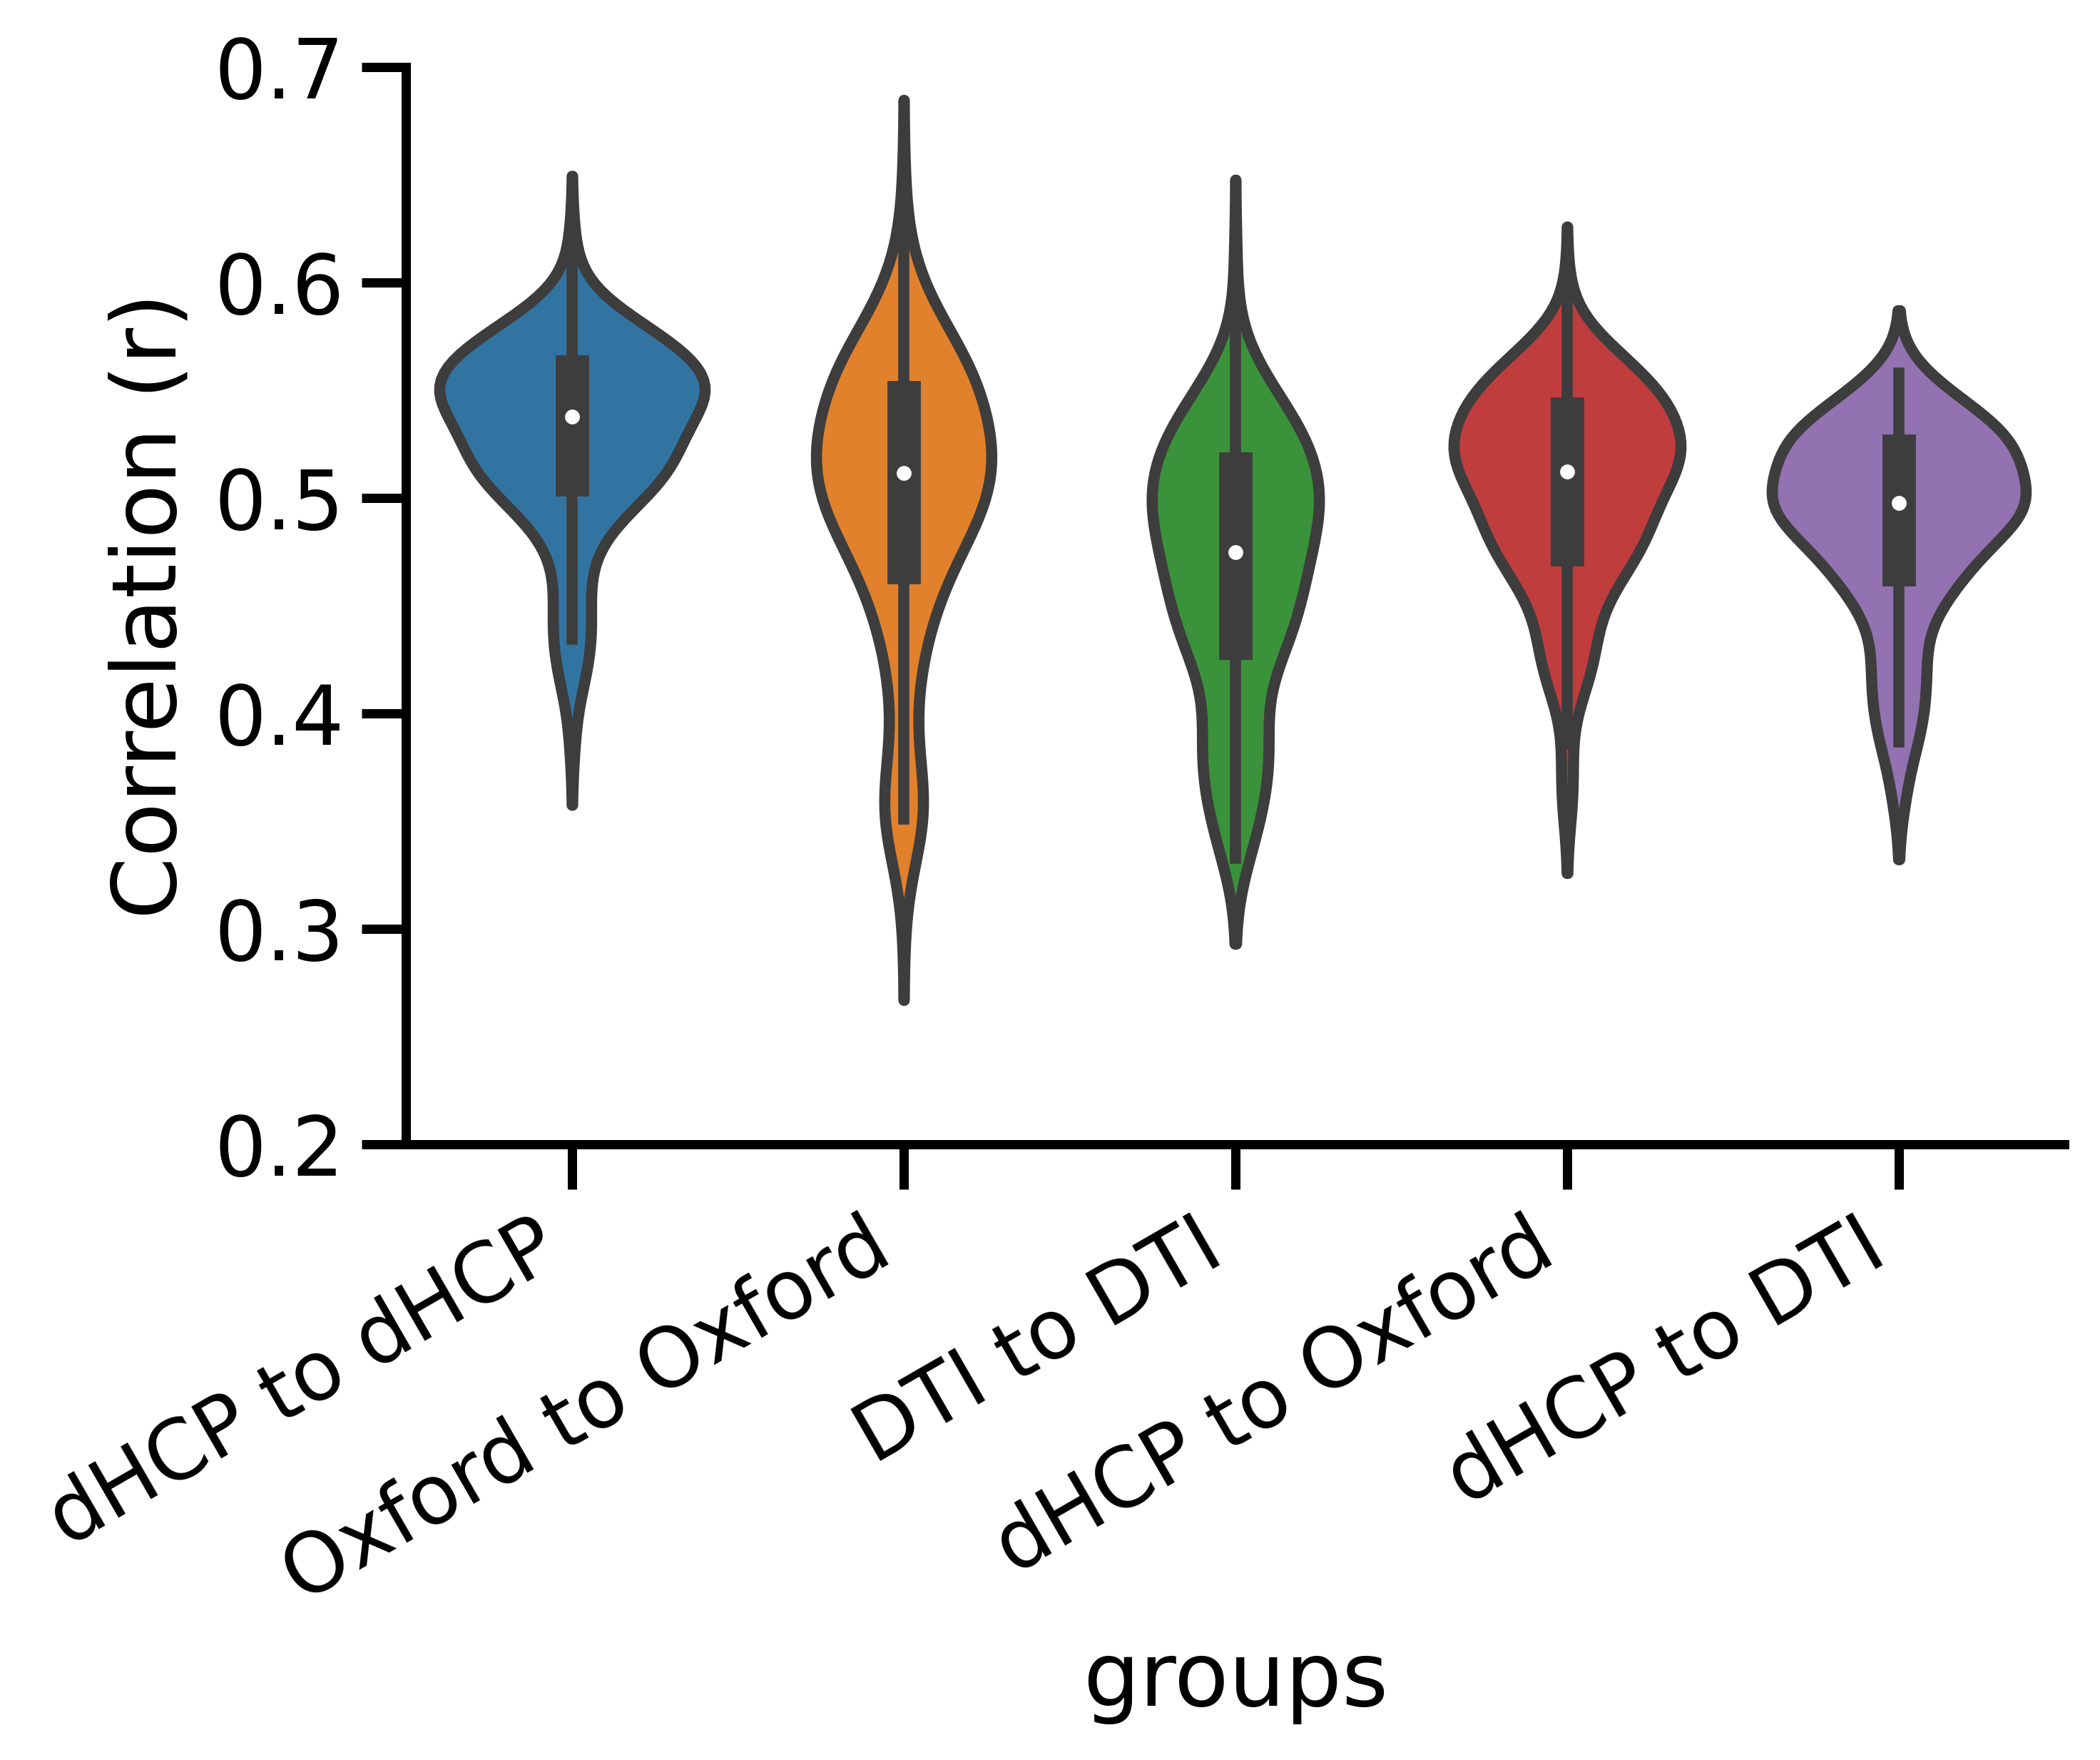

In [19]:
plt.rcParams["figure.dpi"]=500
sns.set_context("talk")

g= sns.violinplot( data=df_sum, x="groups", y="Correlation (r)", palette="tab10",
                 order= ["dHCP to dHCP", "Oxford to Oxford", "DTI to DTI",
                         "dHCP to Oxford", "dHCP to DTI"])
g.set_ylim([0.2, 0.7])
g.set_xticklabels(g.get_xticklabels(), rotation=30, ha="right")
#g.set_yticklabels(g.get_yticklabels(),size=7)

sns.despine()

In [12]:
df_sum.groupby("groups").median()

,sub1,sub2,Correlation (r)
groups,,,
DTI to DTI,7,16,0.474841
Oxford to Oxford,7,16,0.511429
dHCP to DTI,7,16,0.497692
dHCP to Oxford,7,16,0.512262
dHCP to dHCP,7,16,0.537857


In [13]:
df_sum.groupby("groups").std()

,sub1,sub2,Correlation (r)
groups,,,
DTI to DTI,5.066228,5.066228,0.059135
Oxford to Oxford,5.066228,5.066228,0.065321
dHCP to DTI,5.066228,5.066228,0.043482
dHCP to Oxford,5.066228,5.066228,0.045182
dHCP to dHCP,5.066228,5.066228,0.041837


In [14]:
print("corrected p-value = ", 0.05/10)

corrected p-value =  0.005


In [15]:
mannwhitneyu(df_sum[df_sum.groups=="dHCP to dHCP"]["Correlation (r)"], df_sum[df_sum.groups=="Oxford to Oxford"]["Correlation (r)"])

MannwhitneyuResult(statistic=18891.0, pvalue=2.8434470771435934e-08)

In [16]:
mannwhitneyu(df_sum[df_sum.groups=="dHCP to dHCP"]["Correlation (r)"], df_sum[df_sum.groups=="Clinical to Clinical"]["Correlation (r)"])

/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:7171: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd


MannwhitneyuResult(statistic=0.0, pvalue=0.0)

In [17]:
mannwhitneyu(df_sum[df_sum.groups=="dHCP to dHCP"]["Correlation (r)"], df_sum[df_sum.groups=="dHCP to Oxford"]["Correlation (r)"])

MannwhitneyuResult(statistic=17520.0, pvalue=8.633573674692038e-11)

In [18]:
mannwhitneyu(df_sum[df_sum.groups=="dHCP to dHCP"]["Correlation (r)"], df_sum[df_sum.groups=="dHCP to Clinical"]["Correlation (r)"])

MannwhitneyuResult(statistic=0.0, pvalue=0.0)

In [19]:
mannwhitneyu(df_sum[df_sum.groups=="Oxford to Oxford"]["Correlation (r)"], df_sum[df_sum.groups=="Clinical to Clinical"]["Correlation (r)"])

MannwhitneyuResult(statistic=0.0, pvalue=0.0)

In [20]:
mannwhitneyu(df_sum[df_sum.groups=="Oxford to Oxford"]["Correlation (r)"], df_sum[df_sum.groups=="dHCP to Oxford"]["Correlation (r)"])

MannwhitneyuResult(statistic=26553.5, pvalue=0.46487417168816025)

In [21]:
mannwhitneyu(df_sum[df_sum.groups=="Oxford to Oxford"]["Correlation (r)"], df_sum[df_sum.groups=="dHCP to Clinical"]["Correlation (r)"])

MannwhitneyuResult(statistic=0.0, pvalue=0.0)

In [22]:
mannwhitneyu(df_sum[df_sum.groups=="Clinical to Clinical"]["Correlation (r)"], df_sum[df_sum.groups=="dHCP to Oxford"]["Correlation (r)"])

MannwhitneyuResult(statistic=0.0, pvalue=0.0)

In [23]:
mannwhitneyu(df_sum[df_sum.groups=="Clinical to Clinical"]["Correlation (r)"], df_sum[df_sum.groups=="dHCP to Clinical"]["Correlation (r)"])

MannwhitneyuResult(statistic=0.0, pvalue=0.0)

In [24]:
mannwhitneyu(df_sum[df_sum.groups=="dHCP to Oxford"]["Correlation (r)"], df_sum[df_sum.groups=="dHCP to Clinical"]["Correlation (r)"])

MannwhitneyuResult(statistic=0.0, pvalue=0.0)